In [1]:
# Standard import
%matplotlib inline
import cv2 as cv
import PIL
import webcolors
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

In [2]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off')
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

In [3]:
urls = [
    "https://images.unsplash.com/photo-1604275140373-704beb23bd69?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604277070156-08c968e93206?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1584530028377-28109fdf2411?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604284195847-88dc4b5a9faa?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604287136593-6ef6eac55c3a?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604257769051-c2158a1c5a8c?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604274608709-f9c2bb7fc658?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60"
]

images = pd.DataFrame(urls)
images.columns = ['urls']
images.head()

,urls
0,https://images.unsplash.com/photo-160427514037...
1,https://images.unsplash.com/photo-160427707015...
2,https://images.unsplash.com/photo-158453002837...
3,https://images.unsplash.com/photo-160428419584...
4,https://images.unsplash.com/photo-160428713659...


In [4]:
# Function to find the closest color based on RGB values
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

# Function to find the english name of a given color (actual color or closest one)
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Display color palette for color clusters
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

# Display color palette for color clusters, with percentages (percentages <=> normalized size of clusters)
def palette_perc(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    step = 0
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
    return palette, perc

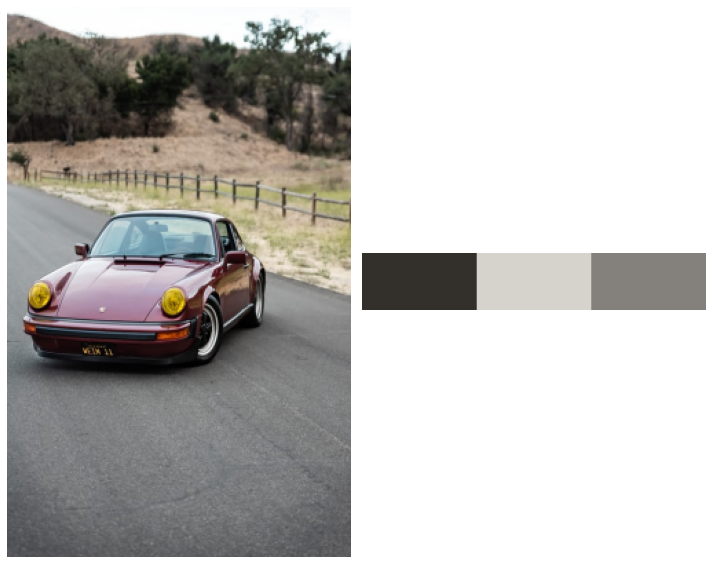

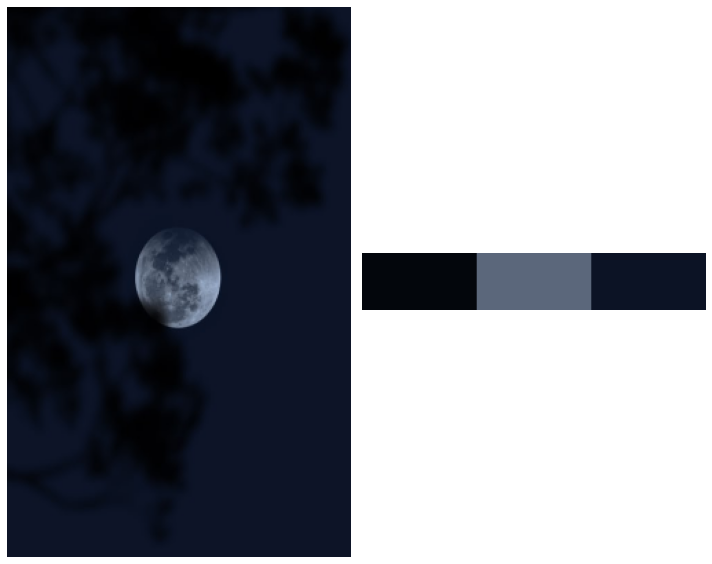

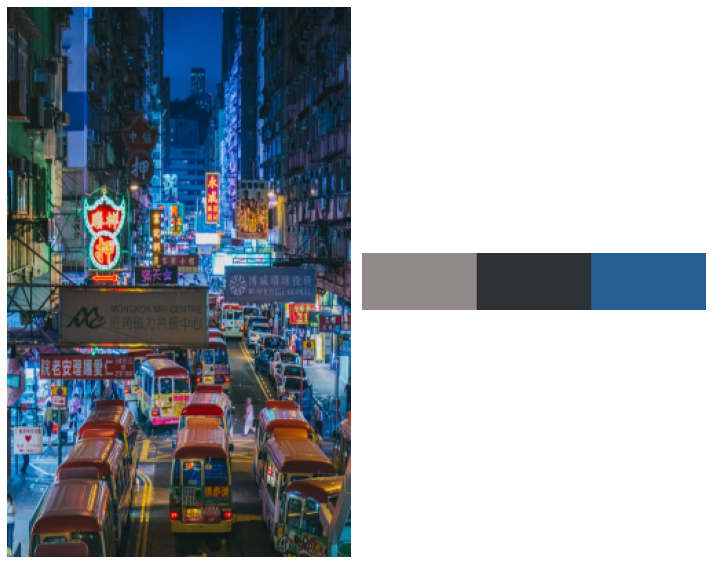

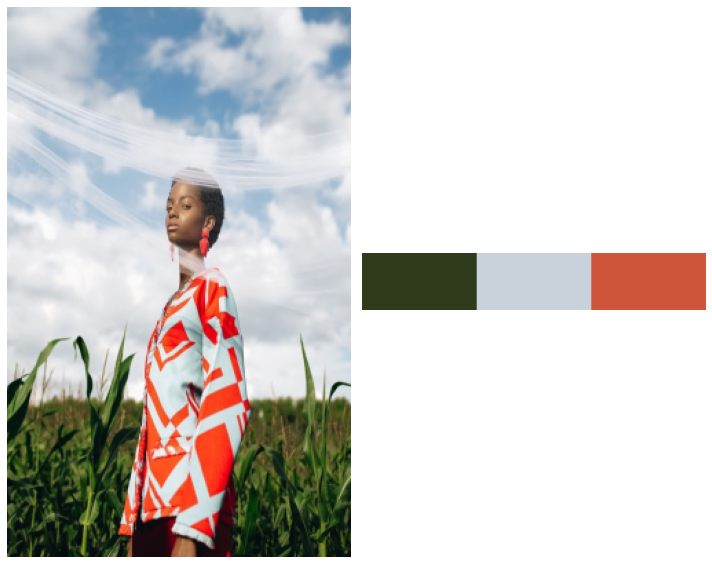

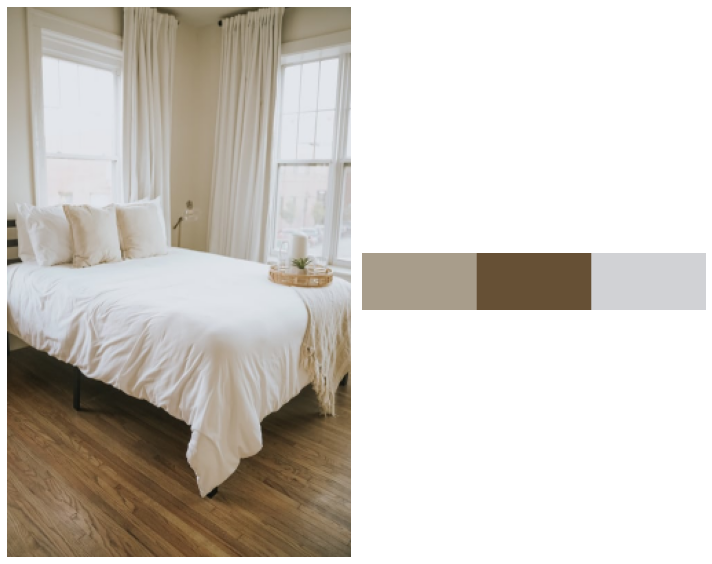

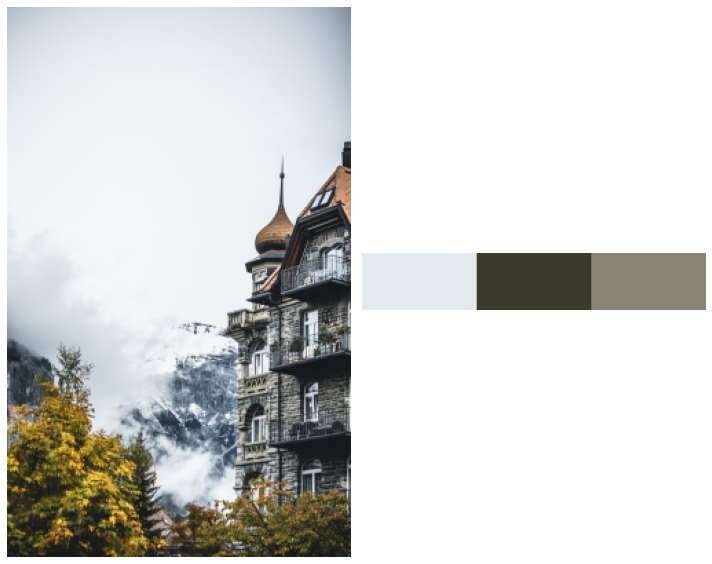

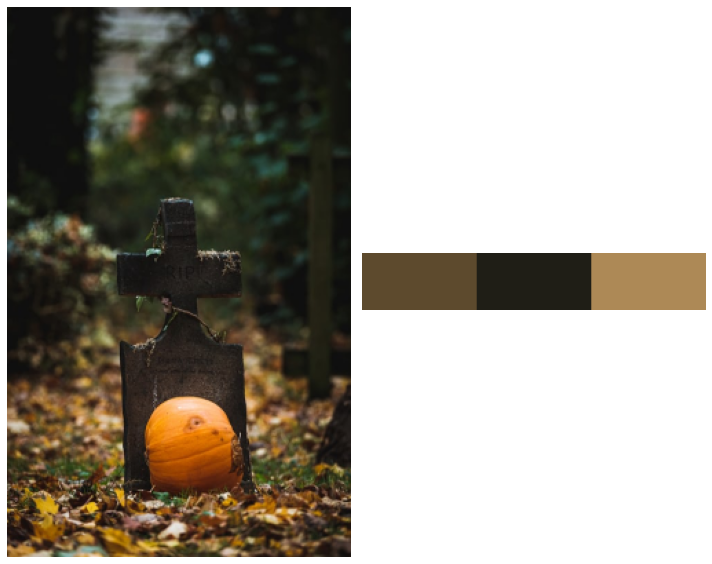

In [5]:
clt=KMeans(n_clusters=3)
urls_colors = []

for url in tqdm(images['urls']):

    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv.imdecode(arr, -1) # 'Load it as it is'
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # resize image
    dim = (250, 400)
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)

    # Fit a KMeans to each image to find the clusters of colors
    clt_1 = clt.fit(img.reshape(-1, 3))
    show_img_compar(img, palette(clt_1))

    colors = {}
    for i in range(3):
        actual_name, closest_name = get_colour_name(tuple([int(x) for x in clt_1.cluster_centers_[i]]))
        if actual_name != None:
            colors[i] = actual_name
        else:
            colors[i] = closest_name

    pal, perc = palette_perc(clt_1)

    data_colors = (url,
                   colors[0],
                   colors[1],
                   colors[2],
                   perc[0],
                   perc[1],
                   perc[2]
                   )

    urls_colors.append(data_colors)

In [6]:
# Create dataframe with colors associated to urls
# Top 3 colors and associated scores
df_colors = pd.DataFrame(urls_colors, columns=['urls', 'color_1', 'color_2', 'color_3', 'score_0', 'score_1', 'score_2'])
df_colors.head()

,urls,color_1,color_2,color_3,score_0,score_1,score_2
0,https://images.unsplash.com/photo-160427514037...,darkslategray,lightgray,gray,0.25,0.16,0.59
1,https://images.unsplash.com/photo-160427707015...,black,dimgray,black,0.39,0.03,0.59
2,https://images.unsplash.com/photo-158453002837...,gray,darkslategray,darkslateblue,0.19,0.61,0.21
3,https://images.unsplash.com/photo-160428419584...,darkslategray,lightgray,indianred,0.23,0.69,0.08
4,https://images.unsplash.com/photo-160428713659...,rosybrown,darkolivegreen,lightgray,0.34,0.28,0.38
